In [1]:
from qiskit.quantum_info import Statevector
from qiskit.visualization.bloch import Bloch
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer
from sympy.physics.matrices import msigma
from sympy import N, re
from numpy import pi
import numpy as np
import math


In [2]:
Aer.backends()
simulator = Aer.get_backend('aer_simulator')
qreg_q = QuantumRegister(1, 'q')
circuit = QuantumCircuit(qreg_q)
clreg = ClassicalRegister(1)

In [3]:
def to_spherical(vec):
    x = np.real(vec[0])
    y = np.real(vec[1])
    z = np.real(vec[2])
    hxy = np.hypot(x, y)
    r = np.hypot(hxy, z)
    ϕ = np.arctan2(y, x) #az
    θ = np.arctan2(z, hxy) #el
    return [r, ϕ, θ]

def to_cartesian(polar):
    r = polar[0]
    ϕ = polar[1]
    θ = polar[2]
    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [np.real(x), np.real(y), np.real(z)]

Use of Operator-class: https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html#Operator-Class

In [4]:
# Matrix taken from
# https://docplayer.org/117986458-Die-symmetriegruppen-so-3-und-su-2.html (p. 11, equation 46)
# https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf (p. 8, equation 50)

def rn_su2(theta, n):
    if not math.isclose(np.linalg.norm(n), 1, rel_tol = 0.000001):
        print("Magnitude of n must be 1!")
        return None
    
    n1 = n[0]
    n2 = n[1]
    n3 = n[2]

    return Operator([
        [np.cos(theta/2) - 1j*n3*np.sin(theta/2), -1j*(n1 - 1j*n2)*np.sin(theta/2)],
        [-1j*(n1 + 1j*n2)*np.sin(theta/2), np.cos(theta/2) + 1j*n3*np.sin(theta/2)]
    ], input_dims=(2, 1), output_dims=(2, 1))

# Magnitude of the vector n must be 1
# see https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf
n = [0, 0, 1]
#n = [1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)]

# Debug: check if the matrix is unitary
mat = np.array(rn_su2(pi, n))
# Compute A^dagger.A and see if it is identity matrix
mat = np.conj(mat.T).dot(mat)
print(mat)

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


[1.0, 0.0, 0.0]
Matrix([[(0.995184726672197 - 0.0980171403295606*I)**2, 0], [0, (-0.995184726672197 - 0.0980171403295606*I)*(0.995184726672197 + 0.0980171403295606*I)]])
0.1963495408493616
1.5707963267948966


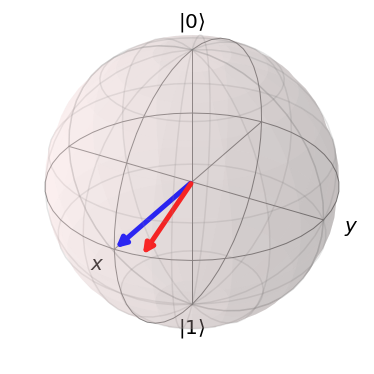

In [11]:
# perform a single rotation:
rot_angle = pi/16

# Magnitude of the vector n must be 1
# see https://www.uni-muenster.de/Physik.TP/archive/fileadmin/lehre/teilchen/ws1011/SO3SU2.pdf
n = [0, 0, 1]

start_vec = [1, 0, 0]

_bloch = Bloch()
_bloch.vector_color = ['blue', 'red']

sv = []
vec = start_vec
sv.append(vec)

spherical_vec = to_spherical(vec)
ϕ = spherical_vec[1]
θ = spherical_vec[2]
print(spherical_vec)

# https://www.phys.hawaii.edu/~yepez/Spring2013/lectures/Lecture1_Qubits_Notes.pdf (p. 3)
sx = msigma(1)
sy = msigma(2)
sz = msigma(3)
M_q = (np.sin(θ)*np.cos(ϕ)*sx + np.sin(θ)*np.sin(ϕ)*sy + np.cos(θ)*sz)
U_n = np.eye(2)*np.cos(rot_angle/2) -1j*(n[0]*sx+n[1]*sy+n[2]*sz)*np.sin(rot_angle/2)
M_q_rotated = U_n*M_q*np.matrix(U_n).H

#rot_operator = rn_su2(rot_angle, n)
#rot_matrix = np.array(rot_operator)
#M_q_rotated = rot_matrix*M_q*np.matrix(rot_matrix).H

print(M_q_rotated)
cos_θ_rotated = float(N(re(M_q_rotated[0,0])))
θ_rotated = np.arccos(cos_θ_rotated)
print(θ_rotated)

#e^(ix) = cos(x) + i*sin(x), see https://en.wikipedia.org/wiki/Euler%27s_identity
temp = float(N(re(M_q_rotated[1,0])))
temp = temp/np.sin(θ_rotated)
ϕ_rotated = np.arccos(temp)
print(ϕ_rotated)

vec = np.array(to_cartesian([1, θ_rotated, ϕ_rotated]))
sv.append(vec)

_bloch.add_vectors(sv)
_bloch.render()